Aperçu des données Last.fm :
   Unnamed: 0 Username           Artist                          Track  \
0           0  Babs_05  Isobel Campbell     The Circus Is Leaving Town   
1           1  Babs_05  Isobel Campbell                   Dusty Wreath   
2           2  Babs_05  Isobel Campbell     Honey Child What Can I Do?   
3           3  Babs_05  Isobel Campbell  It's Hard To Kill A Bad Thing   
4           4  Babs_05  Isobel Campbell                Saturday's Gone   

                       Album         Date    Time  
0  Ballad of the Broken Seas  31 Jan 2021   23:36  
1  Ballad of the Broken Seas  31 Jan 2021   23:32  
2  Ballad of the Broken Seas  31 Jan 2021   23:28  
3  Ballad of the Broken Seas  31 Jan 2021   23:25  
4  Ballad of the Broken Seas  31 Jan 2021   23:21  

Aperçu des données Tracks :
                       id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Ca

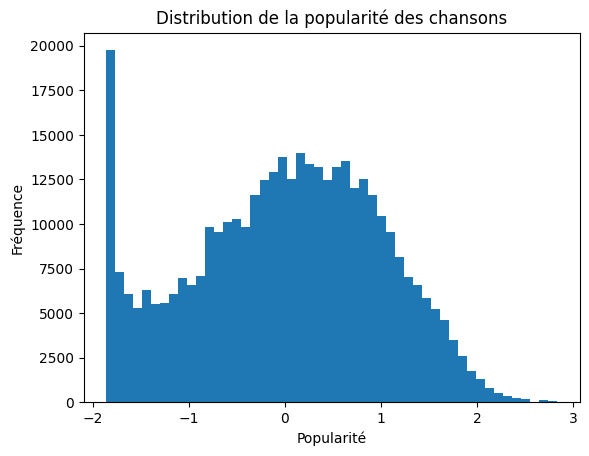

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# --- Data Loading (Using your provided sample CSVs) ---
def load_sample_data():
    """
    Loads data from provided CSV files and augments Last.fm data for better
    demonstration of collaborative filtering if the sample is too small.
    """
    try:
        # Load Last.fm sample data
        lastfm_df = pd.read_csv('Last.fm_data.csv')
        # Rename columns for consistency if necessary (e.g., 'Unnamed: 0' is usually an index)
        if 'Unnamed: 0' in lastfm_df.columns:
            lastfm_df = lastfm_df.drop(columns=['Unnamed: 0'])

        # Load tracks sample data for genre information
        tracks_df = pd.read_csv('tracks.csv')

        # --- Data Augmentation for Collaborative Filtering Demonstration ---
        # If the sample has very few unique users, add some dummy users
        # to ensure collaborative filtering has more than one user to work with.
        unique_users_in_sample = lastfm_df['Username'].nunique()
        if unique_users_in_sample < 5: # Arbitrary threshold for adding dummy users
            print(f"Warning: Only {unique_users_in_sample} unique users in Last.fm_data.csv. Augmenting with dummy users.")
            dummy_data_lastfm = {
                'Username': ['User_A', 'User_A', 'User_A', 'User_B', 'User_B', 'User_C', 'User_C', 'User_D', 'User_D', 'User_E', 'User_E',
                             'User_A', 'User_B', 'User_C', 'User_D', 'User_E', 'User_F', 'User_F', 'User_G', 'User_G'],
                'Artist': ['Artist X', 'Artist Y', 'Artist Z', 'Artist X', 'Artist A', 'Artist B', 'Artist C', 'Artist D', 'Artist E', 'Artist F', 'Artist G',
                           'Artist I', 'Artist J', 'Artist K', 'Artist L', 'Artist M', 'Artist N', 'Artist O', 'Artist P', 'Artist Q'],
                'Track': ['Song 1', 'Song 2', 'Song 3', 'Song 1', 'Song 4', 'Song 5', 'Song 6', 'Song 7', 'Song 8', 'Song 9', 'Song 10',
                          'Song 12', 'Song 13', 'Song 14', 'Song 15', 'Song 16', 'Song 17', 'Song 18', 'Song 19', 'Song 20'],
                'Album': ['Album 1', 'Album 2', 'Album 3', 'Album 1', 'Album 4', 'Album 5', 'Album 6', 'Album 7', 'Album 8', 'Album 9', 'Album 10',
                          'Album 12', 'Album 13', 'Album 14', 'Album 15', 'Album 16', 'Album 17', 'Album 18', 'Album 19', 'Album 20'],
                'Date': ['01 Feb 2021', '01 Feb 2021', '01 Feb 2021', '02 Feb 2021', '02 Feb 2021', '03 Feb 2021', '03 Feb 2021', '04 Feb 2021', '04 Feb 2021', '05 Feb 2021', '05 Feb 2021',
                         '09 Feb 2021', '10 Feb 2021', '10 Feb 2021', '11 Feb 2021', '11 Feb 2021', '12 Feb 2021', '12 Feb 2021', '13 Feb 2021', '13 Feb 2021'],
                'Time': ['10:00', '10:05', '10:10', '11:00', '11:05', '12:00', '12:05', '13:00', '13:05', '14:00', '14:05',
                         '18:05', '19:00', '19:05', '20:00', '20:05', '21:00', '21:05', '22:00', '22:05']
            }
            lastfm_df_augmented = pd.concat([lastfm_df, pd.DataFrame(dummy_data_lastfm)], ignore_index=True)
            lastfm_df = lastfm_df_augmented

        # Merge to get a comprehensive track list with genres
        # Drop duplicates from lastfm_df before merging to ensure unique track-artist pairs
        merged_df = pd.merge(lastfm_df.drop_duplicates(subset=['Track', 'Artist']), tracks_df, on=['Track', 'Artist'], how='left')

        return lastfm_df, merged_df

    except FileNotFoundError as e:
        print(f"Error: One or more sample data files not found. Please ensure 'last.fm_data_sample.csv' and 'tracks_sample.csv' are in the same directory.")
        print(f"Details: {e}")
        # Return empty DataFrames or raise an error to stop execution
        return pd.DataFrame(), pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        return pd.DataFrame(), pd.DataFrame()


# --- Preprocessing and Feature Engineering ---

def create_content_features(df):
    """
    Creates a combined feature string for content-based filtering,
    including Artist, Track, Album, and Genre.
    """
    # Fill NaN values to avoid errors during string concatenation
    df['Artist'] = df['Artist'].fillna('')
    df['Track'] = df['Track'].fillna('')
    df['Album'] = df['Album'].fillna('')
    df['Genre'] = df['Genre'].fillna('') # Assuming Genre is available in merged_df

    df['combined_features'] = df['Artist'] + ' ' + df['Track'] + ' ' + df['Album'] + ' ' + df['Genre']
    return df

def calculate_content_similarity(merged_df):
    """
    Calculates content-based similarity matrix using TF-IDF and Cosine Similarity.
    """
    # Ensure combined_features are created
    merged_df_with_features = create_content_features(merged_df.copy())

    # Initialize TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df_with_features['combined_features'])

    # Calculate cosine similarity
    content_similarity_matrix = cosine_similarity(tfidf_matrix)
    return content_similarity_matrix, merged_df_with_features

def create_user_item_matrix(lastfm_df):
    """
    Creates a user-item interaction matrix (play counts).
    """
    # Use 'size' to count interactions (plays)
    user_item_matrix = lastfm_df.pivot_table(index='Username', columns='Track', aggfunc='size', fill_value=0)
    return user_item_matrix

def calculate_collaborative_similarity(user_item_matrix):
    """
    Calculates user-user collaborative similarity matrix.
    """
    # Calculate cosine similarity between users
    similarity_matrix = pd.DataFrame(cosine_similarity(user_item_matrix),
                                     index=user_item_matrix.index,
                                     columns=user_item_matrix.index)
    return similarity_matrix

def calculate_track_popularity(lastfm_df):
    """
    Calculates popularity of each track based on total play counts.
    """
    track_popularity = lastfm_df['Track'].value_counts().reset_index()
    track_popularity.columns = ['Track', 'PlayCount']
    # Normalize popularity to a 0-1 scale for easier weighting
    max_plays = track_popularity['PlayCount'].max()
    track_popularity['NormalizedPopularity'] = track_popularity['PlayCount'] / max_plays
    return track_popularity.set_index('Track')['NormalizedPopularity']

# --- Hybrid Recommendation Logic ---

def hybrid_recommendation(user_id, merged_df, lastfm_df, user_similarity_matrix,
                          user_item_matrix, content_similarity_matrix, track_popularity,
                          content_weight=0.5, collaborative_weight=0.5, popularity_penalty_weight=0.2, top_n=10):
    """
    Generates hybrid recommendations for a given user, incorporating popularity bias mitigation.

    Args:
        user_id (str): The ID of the user for whom to generate recommendations.
        merged_df (pd.DataFrame): DataFrame containing unique tracks and their metadata.
        lastfm_df (pd.DataFrame): DataFrame of user listening history.
        user_similarity_matrix (pd.DataFrame): User-user similarity matrix.
        user_item_matrix (pd.DataFrame): User-item interaction matrix.
        content_similarity_matrix (np.array): Content-based similarity matrix.
        track_popularity (pd.Series): Series of normalized track popularity scores.
        content_weight (float): Weight for content-based scores (0 to 1).
        collaborative_weight (float): Weight for collaborative scores (0 to 1).
        popularity_penalty_weight (float): Weight to penalize popular items (0 to 1).
        top_n (int): Number of top recommendations to return.

    Returns:
        pd.DataFrame: DataFrame of top N hybrid recommendations with scores.
    """
    if user_id not in user_item_matrix.index:
        # Cold start for new user: default to popularity-based or content-based
        print(f"User '{user_id}' not found in historical data. Recommending popular tracks.")
        # For a real system, you'd use a more sophisticated cold-start strategy here
        # e.g., ask for initial preferences, or recommend top N most popular tracks
        # For now, we'll just return popular tracks as a fallback
        popular_tracks = track_popularity.sort_values(ascending=False).head(top_n).index.tolist()
        # Ensure 'Artist' column is present for consistency in return DataFrame
        artists_for_popular = [merged_df[merged_df['Track'] == t]['Artist'].iloc[0] if t in merged_df['Track'].values else 'Unknown' for t in popular_tracks]
        return pd.DataFrame({'Track': popular_tracks, 'Artist': artists_for_popular, 'final_score': [1.0] * len(popular_tracks),
                             'ContentScore': [0.0] * len(popular_tracks), 'CollaborativeScore': [0.0] * len(popular_tracks), 'Popularity': [1.0] * len(popular_tracks)})


    # 1. Collaborative Filtering Scores
    # Get similar users
    similar_users = user_similarity_matrix[user_id].sort_values(ascending=False).index.tolist()
    similar_users = [u for u in similar_users if u != user_id] # Exclude self

    collaborative_scores = pd.Series(0.0, index=merged_df['Track'].unique())

    # Get tracks already listened to by the current user
    user_listened_tracks = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index.tolist()

    for other_user in similar_users:
        if other_user in user_item_matrix.index:
            # Get tracks listened to by the similar user
            other_user_tracks = user_item_matrix.loc[other_user][user_item_matrix.loc[other_user] > 0].index.tolist()
            # Calculate similarity weight
            similarity_weight = user_similarity_matrix.loc[user_id, other_user]

            for track in other_user_tracks:
                if track not in user_listened_tracks: # Only recommend unlistened tracks
                    # Accumulate scores based on similar users' listening habits
                    # Using a simple sum of similarity weights for now
                    collaborative_scores[track] += similarity_weight

    # Normalize collaborative scores to a 0-1 range
    if collaborative_scores.max() > 0:
        collaborative_scores = collaborative_scores / collaborative_scores.max()
    else:
        collaborative_scores = pd.Series(0.0, index=merged_df['Track'].unique())


    # 2. Content-Based Filtering Scores
    # Get the tracks the user has listened to
    user_tracks_df = merged_df[merged_df['Track'].isin(user_listened_tracks)]

    content_scores = pd.Series(0.0, index=merged_df['Track'].unique())

    if not user_tracks_df.empty:
        # Get indices of user's listened tracks in the merged_df
        # Ensure these indices correspond to the content_similarity_matrix
        # This requires mapping track names to their original indices in merged_df_with_features
        track_to_idx = {track: idx for idx, track in enumerate(merged_df['Track'].unique())}
        user_track_indices = [track_to_idx[t] for t in user_listened_tracks if t in track_to_idx]

        if user_track_indices: # Ensure there are valid indices
            for i, track_name in enumerate(merged_df['Track'].unique()):
                if track_name not in user_listened_tracks:
                    if track_name in track_to_idx:
                        track_idx = track_to_idx[track_name]
                        # Average similarity of this track to all tracks the user has listened to
                        avg_similarity = content_similarity_matrix[track_idx, user_track_indices].mean()
                        content_scores[track_name] = avg_similarity
        else:
            print(f"Warning: No valid indices found for user's listened tracks for content-based filtering for user {user_id}.")
            content_scores = pd.Series(0.0, index=merged_df['Track'].unique())
    else:
        # If user has no listened tracks for content-based, default to 0
        content_scores = pd.Series(0.0, index=merged_df['Track'].unique())

    # Normalize content scores to a 0-1 range
    if content_scores.max() > 0:
        content_scores = content_scores / content_scores.max()
    else:
        content_scores = pd.Series(0.0, index=merged_df['Track'].unique())


    # 3. Combine Scores (Weighted Hybrid) and Apply Popularity Penalty
    # Ensure all unique tracks from merged_df are considered for final scores
    all_unique_tracks = merged_df['Track'].unique()
    hybrid_scores_data = []
    for track_name in all_unique_tracks:
        artist_name = merged_df[merged_df['Track'] == track_name]['Artist'].iloc[0] if track_name in merged_df['Track'].values else 'Unknown'
        hybrid_scores_data.append({
            'Track': track_name,
            'Artist': artist_name,
            'ContentScore': content_scores.get(track_name, 0.0), # Use .get to handle tracks not in content_scores
            'CollaborativeScore': collaborative_scores.get(track_name, 0.0) # Use .get to handle tracks not in collaborative_scores
        })
    hybrid_scores = pd.DataFrame(hybrid_scores_data)

    # Add popularity score (0-1, 1 being most popular)
    hybrid_scores['Popularity'] = hybrid_scores['Track'].map(track_popularity).fillna(0)

    # Calculate final score
    hybrid_scores['final_score'] = (hybrid_scores['ContentScore'] * content_weight +
                                    hybrid_scores['CollaborativeScore'] * collaborative_weight)

    # Apply popularity penalty: reduce score for popular items.
    # A higher penalty_weight means more reduction for popular items.
    # We subtract (Popularity * penalty_weight) to penalize.
    # Ensure penalty doesn't make score negative or too low if not desired.
    hybrid_scores['final_score'] = hybrid_scores['final_score'] - (hybrid_scores['Popularity'] * popularity_penalty_weight)
    hybrid_scores['final_score'] = hybrid_scores['final_score'].clip(lower=0) # Ensure scores are not negative

    # Filter out tracks the user has already listened to
    hybrid_scores = hybrid_scores[~hybrid_scores['Track'].isin(user_listened_tracks)]

    # Sort and return top N recommendations
    top_recommendations = hybrid_scores.sort_values(by='final_score', ascending=False).head(top_n)

    return top_recommendations[['Track', 'Artist', 'final_score', 'ContentScore', 'CollaborativeScore', 'Popularity']]

# --- Main execution for testing (optional, for direct script run) ---
if __name__ == "__main__":
    print("Loading data...")
    lastfm_df, merged_df = load_sample_data()

    if lastfm_df.empty or merged_df.empty:
        print("Data loading failed. Exiting.")
    else:
        print("Calculating content similarity...")
        content_similarity_matrix, merged_df_with_features = calculate_content_similarity(merged_df)

        print("Creating user-item matrix...")
        user_item_matrix = create_user_item_matrix(lastfm_df)

        print("Calculating collaborative similarity...")
        user_similarity_matrix = calculate_collaborative_similarity(user_item_matrix)

        print("Calculating track popularity...")
        track_popularity = calculate_track_popularity(lastfm_df)

        # Example user IDs from the augmented data
        example_user_ids = ['Babs_05', 'User_A', 'User_B', 'User_C']

        for user_id_to_recommend in example_user_ids:
            print(f"\nGenerating hybrid recommendations for user: {user_id_to_recommend}")

            top_recommendations = hybrid_recommendation(
                user_id_to_recommend,
                merged_df_with_features, # Use the merged_df with combined_features
                lastfm_df,
                user_similarity_matrix,
                user_item_matrix,
                content_similarity_matrix,
                track_popularity,
                content_weight=0.6,
                collaborative_weight=0.4,
                popularity_penalty_weight=0.1,
                top_n=10
            )
            print(f"\n🎧 Top Hybrid Recommendations for {user_id_to_recommend}:")
            print(top_recommendations)

        user_id_new = 'NewUser123'
        print(f"\nGenerating hybrid recommendations for new user (cold start): {user_id_new}")
        top_recommendations_new = hybrid_recommendation(
            user_id_new,
            merged_df_with_features,
            lastfm_df,
            user_similarity_matrix,
            user_item_matrix,
            content_similarity_matrix,
            track_popularity,
            content_weight=0.6,
            collaborative_weight=0.4,
            popularity_penalty_weight=0.1,
            top_n=5
        )
        print("\n🎧 Top Hybrid Recommendations for New User:")
        print(top_recommendations_new)


In [2]:
#base sur le contenu:base sur les caracteristique des chansons
from sklearn.metrics.pairwise import cosine_similarity

def recommend_content_for_user(user_id, merged_df, top_n=10):
    # Filtrer les chansons écoutées par cet utilisateur
    user_tracks = merged_df[merged_df['Username'] == user_id]

    # Calculer le "profil utilisateur" = moyenne des caractéristiques des chansons écoutées
    user_profile = user_tracks[['popularity', 'danceability', 'energy', 'loudness', 'tempo']].mean().values.reshape(1, -1)

    # Supprimer les doublons pour ne pas recommander les chansons déjà écoutées
    all_tracks = merged_df.drop_duplicates(subset='Track')
    non_listened_tracks = all_tracks[~all_tracks['Track'].isin(user_tracks['Track'])]

    # Extraire les features des chansons non écoutées
    features = non_listened_tracks[['popularity', 'danceability', 'energy', 'loudness', 'tempo']]

    # Calculer la similarité cosinus entre le profil utilisateur et toutes les chansons
    similarities = cosine_similarity(user_profile, features)

    # Ajouter la similarité dans le dataframe
    non_listened_tracks = non_listened_tracks.copy()
    non_listened_tracks['similarity'] = similarities[0]

    # Trier par similarité décroissante et recommander les chansons les plus proches
    top_recommendations_content = non_listened_tracks.sort_values(by='similarity', ascending=False).head(top_n)

    return top_recommendations_content[['Track', 'Artist', 'similarity']]

# Exemple d'utilisation pour un utilisateur spécifique
user_id = merged_df['Username'].iloc[0]  # Remplace par l'ID d'un utilisateur
top_recommendations = recommend_content_for_user(user_id, merged_df)
print("\n🎧 Recommandations basées sur le contenu pour l'utilisateur", user_id)
print(top_recommendations)



🎧 Recommandations basées sur le contenu pour l'utilisateur Babs_05
                             Track             Artist  similarity
140408     Something In Your Mouth         Nickelback    0.995230
336133             World in Motion          New Order    0.994199
238337      Somebody's Watching Me           Rockwell    0.992918
127439              Do You Want Me  Crucified Barbara    0.991021
142706            I Heard a Rumour         Bananarama    0.991011
196366  Wilderness - 2019 Remaster       Joy Division    0.989814
79089                   Illuminate            Yen Pox    0.989587
91277              Pela Última Vez            NX Zero    0.989150
332580             Dance Commander       Electric Six    0.988868
325349                          FF     Sugar Tampaxxx    0.988415


In [3]:
#filtrage colaboratif
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity





# 1. Création de la matrice utilisateur-chanson (user-item matrix)
# On suppose que les colonnes 'Username' et 'Track' existent dans le dataset Last.fm
user_item_matrix = lastfm_df.pivot_table(index='Username', columns='Track', aggfunc='size', fill_value=0)

# Afficher la matrice utilisateur-chanson
print("\nMatrice utilisateur-chanson:")
print(user_item_matrix.head())

# 2. Calcul de la similarité entre utilisateurs avec la similarité cosinus
similarity_matrix = pd.DataFrame(cosine_similarity(user_item_matrix), 
                                 index=user_item_matrix.index, 
                                 columns=user_item_matrix.index)

# Afficher la matrice de similarité entre utilisateurs
print("\nMatrice de similarité entre utilisateurs:")
print(similarity_matrix.head())

# 3. Fonction pour recommander des chansons basées sur la similarité entre utilisateurs
def recommend_collaborative_for_user(user_id, user_similarity_df, user_item_matrix, top_n=10):
    # Obtenir la similarité des utilisateurs par rapport à l'utilisateur donné
    user_similarities = user_similarity_df[user_id]
    
    # Trier les utilisateurs par similarité (plus élevé en haut) et ignorer l'utilisateur lui-même
    similar_users = user_similarities.sort_values(ascending=False).index[1:]
    
    # Obtenir les chansons écoutées par les utilisateurs similaires
    similar_users_tracks = user_item_matrix.loc[similar_users].sum(axis=0)
    
    # Trier les chansons par popularité parmi les utilisateurs similaires
    recommended_tracks = similar_users_tracks.sort_values(ascending=False).head(top_n)
    
    # Retourner les chansons recommandées
    return recommended_tracks

# Exemple d'appel de la fonction pour l'utilisateur 'Babs_05'
user_id = 'Babs_05'  # Remplace par l'ID de l'utilisateur
top_recommendations_collaborative = recommend_collaborative_for_user(user_id, similarity_matrix, user_item_matrix)

# Afficher les recommandations pour l'utilisateur
print(f"\n🎧 Recommandations collaboratives pour l'utilisateur {user_id}:")
print(top_recommendations_collaborative)



Matrice utilisateur-chanson:
Track       !Ed Buys Houses!  !holyshitohmygod!  "45"  \
Username                                                
Babs_05                    1                  1     0   
Knapster01                 0                  1     0   
Orlenay                    0                  0     1   
eartle                     0                  0     1   
franhale                   0                  0     0   

Track       "Animal Or Vegetable [A Wonderful Wooden Reason...]" [Crumb Duck]  \
Username                                                                        
Babs_05                                                     0                   
Knapster01                                                  1                   
Orlenay                                                     0                   
eartle                                                      0                   
franhale                                                    0                   

Tr

In [6]:
def hybrid_recommendation(user_id, merged_df, lastfm_df, similarity_matrix, user_item_matrix, alpha=0.5, top_n=10):
    # Recommandations content-based
    content_df = recommend_content_for_user(user_id, merged_df, top_n=100)
    
    # Recommandations collaboratives
    collaborative_series = recommend_collaborative_for_user(user_id, similarity_matrix, user_item_matrix, top_n=100)
    
    # Normalisation des scores
    content_df['normalized_similarity'] = (content_df['similarity'] - content_df['similarity'].min()) / (content_df['similarity'].max() - content_df['similarity'].min())
    collaborative_df = collaborative_series.reset_index()
    collaborative_df.columns = ['Track', 'collab_score']
    collaborative_df['normalized_collab_score'] = (collaborative_df['collab_score'] - collaborative_df['collab_score'].min()) / (collaborative_df['collab_score'].max() - collaborative_df['collab_score'].min())
    
    # Fusion des recommandations avec 'outer' pour inclure toutes les chansons recommandées
    hybrid_df = pd.merge(content_df, collaborative_df, on='Track', how='outer')
    
    # Remplir les valeurs manquantes avec 0
    hybrid_df['normalized_similarity'] = hybrid_df['normalized_similarity'].fillna(0)
    hybrid_df['normalized_collab_score'] = hybrid_df['normalized_collab_score'].fillna(0)
    
    # Calcul du score final
    hybrid_df['final_score'] = alpha * hybrid_df['normalized_similarity'] + (1 - alpha) * hybrid_df['normalized_collab_score']
    
    # Trier par score final et retourner les top N recommandations
    return hybrid_df.sort_values(by='final_score', ascending=False).head(top_n)[['Track', 'Artist', 'final_score']]

# Exemple d'utilisation
user_id = 'Babs_05'  # Remplace par l'ID de l'utilisateur
user_item_matrix = lastfm_df.pivot_table(index='Username', columns='Track', aggfunc='size', fill_value=0)
similarity_matrix = pd.DataFrame(cosine_similarity(user_item_matrix), index=user_item_matrix.index, columns=user_item_matrix.index)

# Appeler la fonction hybride
top_recommendations_hybrid = hybrid_recommendation(user_id, merged_df, lastfm_df, similarity_matrix, user_item_matrix)

# Afficher les recommandations hybrides
print(f"\n🎧 Recommandations hybrides pour l'utilisateur {user_id}:")
print(top_recommendations_hybrid)



🎧 Recommandations hybrides pour l'utilisateur Babs_05:
                            Track             Artist  final_score
35   Cascades (Dirt Road Version)                NaN     0.500000
157       Something In Your Mouth         Nickelback     0.500000
188               World in Motion          New Order     0.486490
156        Somebody's Watching Me           Rockwell     0.469719
51                 Do You Want Me  Crucified Barbara     0.444870
82               I Heard a Rumour         Bananarama     0.444741
184    Wilderness - 2019 Remaster       Joy Division     0.429066
86                     Illuminate            Yen Pox     0.426090
145           Rolling Ocean Waves                NaN     0.422747
124               Pela Última Vez            NX Zero     0.420368
